In [1]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model_settings import ms
from pathlib import Path
ms.find_root(Path())
models_dir = os.path.join(ms.root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('.')==-1]
for i,m in enumerate(models):
    print(f"{i}  {m}")
i = int(input('select model: '))
model_dir = os.path.join(models_dir,models[i])
pickle = os.path.join(model_dir,models[i]+'.pkl')

def test_performance(model,net):
    inpred = net.predict(model['train_X'])
    intar = model['train_data'][model['target_name']].values
    indiff = inpred-intar
    inRMSE = np.sqrt(np.mean(indiff**2))
    inMAE = np.mean(np.abs(indiff))
    print(f"in sample\n   RMSE:\n      {inRMSE}")
    print(f"   MAE:\n      {inMAE}")

    outpred = net.predict(model['test_X'])
    outtar = model['test_data'][model['target_name']].values
    outdiff = outpred-outtar
    outRMSE = np.sqrt(np.mean(outdiff**2))
    outMAE = np.mean(np.abs(outdiff))
    print(f"out of sample\n   RMSE:\n      {outRMSE}")
    print(f"   MAE:\n      {outMAE}")

0  2024-12-03 115353819604 inital cboe spx relative asian
1  2024-12-03 221708375538 inital cboe spx relative barrier
2  2024-12-06 024553040968 inital cboe spx relative barrier
3  2024-12-06 052035159768 inital cboe spx relative asian


select model:  3


In [2]:
model = joblib.load(pickle)

In [3]:
model['mlp_params']

{'solver': 'sgd',
 'activation': 'relu',
 'max_iter': 500,
 'random_state': 710,
 'early_stopping': True,
 'hidden_layer_sizes': (30,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'n_iter_no_change': 20,
 'tol': 0.0001,
 'warm_start': False}

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [5]:
mlp = model['fitted']
mlp[1].out_activation_ = 'relu'

In [6]:
test_performance(model,mlp)

in sample
   RMSE:
      0.0041733873655386946
   MAE:
      0.0027708993755318112
out of sample
   RMSE:
      0.04944591624364071
   MAE:
      0.02296526589156009


In [7]:
print(mlp)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['days_to_maturity',
                                                   'fixing_frequency',
                                                   'past_fixings',
                                                   'risk_free_rate',
                                                   'dividend_rate', 'kappa',
                                                   'theta', 'rho', 'eta', 'v0',
                                                   'relative_spot']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['averaging_type', 'w'])])),
                ('regressor',
                 MLPRegressor(early_stopping=True, hidden_layer_

In [8]:
import pandas as pd
param_df = pd.DataFrame()
for k,v in mlp[1].__dict__.items():
    try:
        param_df.loc[str(k),'specification'] = str(v)
    except Exception:
        pass

param_df = param_df[:31].copy()
param_df = param_df.drop(index=[i for i in param_df.index if i.startswith('_')]).reset_index()
param_df = param_df.rename(columns={'index':'parameter'})
latex_table = param_df.to_latex(index=False, escape=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
parameter & specification \\
\midrule
activation & relu \\
solver & sgd \\
alpha & 0.0001 \\
batch_size & auto \\
learning_rate & adaptive \\
learning_rate_init & 0.1 \\
power_t & 0.5 \\
max_iter & 500 \\
loss & squared_error \\
hidden_layer_sizes & (30,) \\
shuffle & True \\
random_state & 710 \\
tol & 0.0001 \\
verbose & False \\
warm_start & False \\
momentum & 0.9 \\
nesterovs_momentum & True \\
early_stopping & True \\
validation_fraction & 0.1 \\
beta_1 & 0.9 \\
beta_2 & 0.999 \\
epsilon & 1e-08 \\
n_iter_no_change & 20 \\
max_fun & 15000 \\
n_features_in_ & 15 \\
n_outputs_ & 1 \\
n_iter_ & 226 \\
t_ & 5755316 \\
n_layers_ & 3 \\
out_activation_ & relu \\
\bottomrule
\end{tabular}



In [9]:
data = model['test_data']

dates = data['date'].drop_duplicates().reset_index(drop=True)
data = data[data['date'].isin(dates[:20])].copy()
X = data[model['feature_set']]

In [10]:
from lime.lime_tabular import LimeTabularExplainer

preprocessor = model['preprocessor']
X = preprocessor.transform(X)

features = list(preprocessor.get_feature_names_out())
categoricals = []
for i in range(1,len(features)):
    if features[i].find('Encoder')!=-1:
        categoricals.append(i)

features = [f[f.rfind('_',1)+1:] for f in features]

In [11]:
categoricals

[11, 12, 13, 14]

In [12]:
explainer = LimeTabularExplainer(
    training_data=X,
    feature_names=features,
    categorical_features=categoricals,
    class_names=model['target_name'],
    mode='regression',
    verbose=False
)

In [13]:
def exp(instance):
    return explainer.explain_instance(
        data_row=instance,
        predict_fn=mlp[1].predict,
        num_features=len(features)
    )

def return_weights(instance):
    wbar = exp(instance).as_map()[1]
    wbar = sorted(wbar, key=lambda x: x[0])
    return [x[1] for x in wbar]

In [14]:
from joblib import Parallel, delayed
weights = Parallel(n_jobs=-1)(delayed(return_weights)(X[i]) for i in range(X.shape[0]))
wkeys = [c+'_w' for c in features]
weights = pd.DataFrame(weights,columns=wkeys)

In [15]:
data[weights.columns]=weights.values
data

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,kappa_w,theta_w,rho_w,eta_w,v0_w,spot_w,arithmetic_w,geometric_w,call_w,put_w
28296,1425.0,997.500,7,1.0,7,0,geometric,call,0.001675,0.021159,...,-0.002592,0.003275,0.003485,-0.003491,-0.005743,0.117374,0.006590,-0.010631,-0.013316,0.066209
28433,1425.0,1745.625,84,12.0,7,0,geometric,put,0.001675,0.021159,...,-0.000800,0.002100,0.002547,-0.003717,-0.005059,0.019904,0.006239,-0.010269,0.015588,-0.062253
28434,1425.0,1745.625,84,12.0,7,0,arithmetic,call,0.001675,0.021159,...,-0.001417,0.002452,0.002830,-0.004616,-0.004828,0.010983,-0.005871,0.010656,-0.014399,0.063836
28435,1425.0,1745.625,84,12.0,7,0,arithmetic,put,0.001675,0.021159,...,-0.001308,0.002560,0.002737,-0.003959,-0.004592,0.019530,-0.005912,0.010570,0.015504,-0.062763
28436,1425.0,1852.500,84,12.0,7,0,geometric,call,0.001675,0.021159,...,-0.000882,0.002009,0.002651,-0.004381,-0.005358,0.011375,0.005886,-0.010670,-0.014492,0.063344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34633,1496.0,1047.200,28,1.0,28,0,geometric,put,0.001319,0.021439,...,-0.003696,0.001329,0.002788,-0.003912,0.006175,0.105536,0.006505,-0.010081,0.014386,-0.065695
34634,1496.0,1047.200,28,1.0,28,0,arithmetic,call,0.001319,0.021439,...,-0.002830,0.001371,0.003676,-0.003967,0.006507,0.117668,-0.006136,0.010725,-0.013305,0.066785
34635,1496.0,1047.200,28,1.0,28,0,arithmetic,put,0.001319,0.021439,...,-0.003431,0.000723,0.002973,-0.004069,0.005915,0.106173,-0.006448,0.010149,0.014146,-0.065957
34636,1496.0,1159.400,28,1.0,28,0,geometric,call,0.001319,0.021439,...,-0.003273,0.001801,0.003332,-0.003967,0.006570,0.116849,0.006554,-0.010280,-0.013627,0.066472


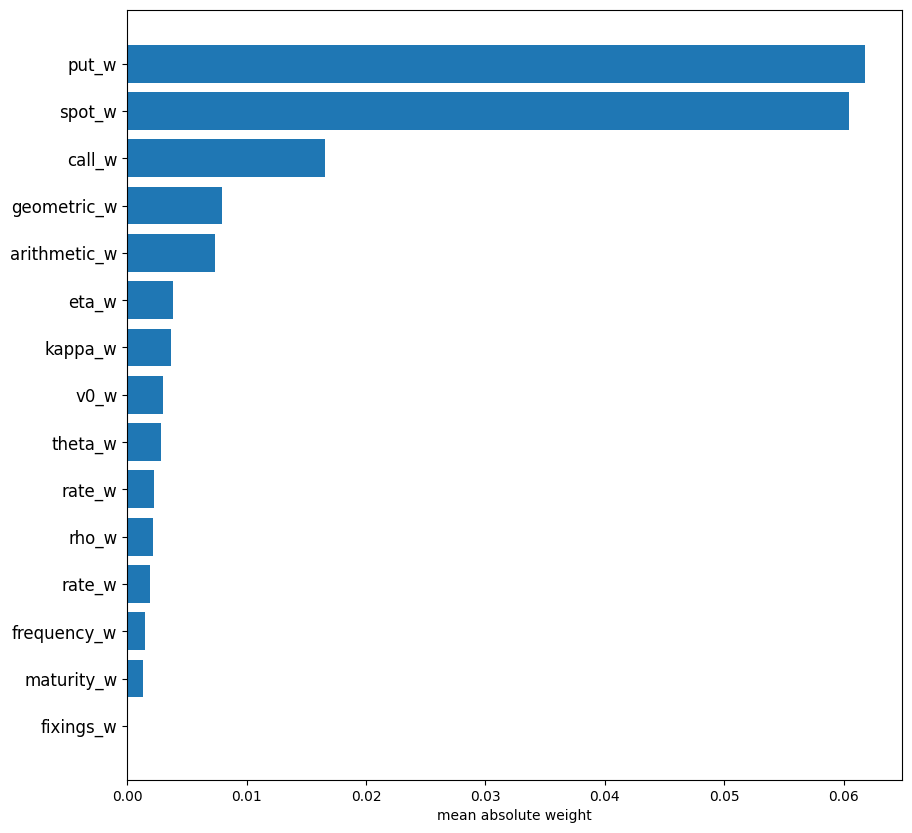

In [16]:
abs_mean = weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y=y_ticks,width=abs_mean.abs_mean)
plt.yticks(ticks=y_ticks,labels=y_labels,size=12)
plt.xlabel('mean absolute weight')
plt.show()

In [22]:
data.columns

Index(['spot_price', 'strike_price', 'days_to_maturity', 'n_fixings',
       'fixing_frequency', 'past_fixings', 'averaging_type', 'w',
       'risk_free_rate', 'dividend_rate', 'calculation_date', 'kappa', 'theta',
       'rho', 'eta', 'v0', 'date', 'asian_price', 'asian_cpu', 'relative_spot',
       'relative_asian_price', 'relative_observed', 'outofsample_target',
       'outofsample_prediction', 'outofsample_error', 'maturity_w',
       'frequency_w', 'fixings_w', 'rate_w', 'kappa_w', 'theta_w', 'rho_w',
       'eta_w', 'v0_w', 'spot_w', 'arithmetic_w', 'geometric_w', 'call_w',
       'put_w'],
      dtype='object')

<Figure size 2100x1500 with 0 Axes>

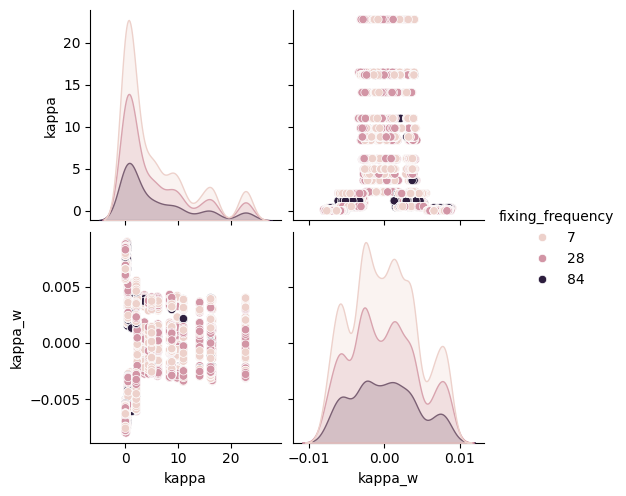

In [35]:
plt.figure(figsize=(7,5),dpi=300)
feature_weight = data['kappa_w']
x = data['kappa']
sns.pairplot(data=data,vars=['kappa','kappa_w'],hue='fixing_frequency')
plt.show()